In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Model

### Description of the building

We consider a building composed of two cubic rooms linked by a door, as described in the figure bellow. 

![plan](Plan.png)
> Figure 1. Description of the building

All the walls except the one between the rooms (refered as exterior walls) are made of concrete and insulation. The wall between the rooms (refered as interior wall) is only composed of concrete. The door is made of oak.

We will impose a constant temperature in the room on the left (refered as adjacent room) to study how the temperature in the second room (principal room) evolves. Therefore, the room on the left will be modelled by a proportional controller and the surfaces of the room on the left are not taken into account in the surface areas for each material.

The dimensions and surface areas of the building are:
- edge length of the cube : $l=3m$
- length of the door : $d=1m$
- surface area of the glass window : $S_g=l^2$ (as explained above, we do not take into account the window of the adjacent room)
- surface area of the exterior walls (concrete and insulation) : $S_c=S_i=4 \times l^2$ (as explained above, we do not take into account the exterior walls of the adjacent room)
- surface area of the interior wall (concrete) : $S_{int}=l \times(l-d)$
- surface of the door : $S_d=l \times d$


In [2]:
# Definition of the geometrical parameters:

l=3  #m
d=1  #m
Sg=l**2
Sc= 4*l**2 
Si= 4*l**2
Sint=l*(l-d)
Sd=l*d

### Thermophysical properties

Thermophysical properties of air : 


In [3]:
#Definition of the parameters of air: 

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


Thermophysical properties of the other materials used :



In [4]:
# Definition of the parameters of the other materials:

concrete_ext = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': Sc}            # m²

insulation = {'Conductivity': 0.027,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': Si}          # m²

glass = {'Conductivity': 1.4,               # W/(m·K)
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 0.04,                     # m
         'Surface': Sg}                   # m²

concrete_int = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': Sint}            # m²

door = {'Conductivity': 0.17,               # W/(m·K)
         'Density': 704,                   # kg/m³
         'Specific heat': 2000,             # J/(kg⋅K)
         'Width': 0.1,                     # m
         'Surface': Sd}                   # m²
#Source : https://material-properties.org/fr/bois-de-chene-densite-resistance-point-de-fusion-conductivite-thermique/?utm_content=cmp-true
        
wall = pd.DataFrame.from_dict({'Layer_out': concrete_ext,
                               'Layer_in': insulation,
                               'Glass': glass,
                               'Interior_wall':concrete_int,
                              'Oak_door' : door},
                              orient='index')
wall


,Conductivity,Density,Specific heat,Width,Surface
Layer_out,1.400,2300.0,880,0.20,36
Layer_in,0.027,55.0,1210,0.08,36
Glass,1.400,2500.0,1210,0.04,9
Interior_wall,1.400,2300.0,880,0.20,6
Oak_door,0.170,704.0,2000,0.10,3


## Radiative properties

The radiative properties of the surfaces are:

- long wave emmisivity of concrete (between normal and rough) and pyrex glass;
- short wave absortivity of solar radiation of white smooth surfaces;
- short wave transmittance of window glass (thickness of 4 mm);
- short wave absortivity and transmittance of reflective blue window glass.


In [5]:
# radiative properties : 

ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

Definition of the Stefan-Boltzmann constant : 

In [6]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


### Convection coefficients

Conventional values for the convection coeficients for indoor and outdoor convection in W/(m²⋅K) are:

In [7]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,8.0,25


## Thermal network

The thermal network of the building is represented in the figure bellow : 

![thermal_network](thermal_network.png)
> Figure 2. Thermal network of the building

The thermal network represents :
- the concrete and insulation outdoor walls in red, 
- the glass window in green,
- the ventilation in purple,
- the indoor air volume in blue,
- the HVAC system in black,
- the indoor wall in orange,
- the door in pink,
- the adjacent room in brown

The sources are:
- $T_o$ - outdoor temperature, °C;
- $T_{i,sp}$ - indoor air controlled at the setpoint temperature for the indoor air, °C;
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
- $T_\infty$ - constant temperature imposed in the room on the left.


*Note*: The known values, i.e. the elements of the circuit (conductances $G$ and capacities $C$) and the sources (of temperature $T$ and of flow rate $\Phi$ or $\dot{Q}$) are noted in uppercase letters. The unknow variables, i.e. the temperatures in the nodes $\theta$ and the flow rates on the branches $q$, are noted in lowercase letters.


### Thermal conductances

#### Conduction

The conductances 1, 2, 3, 4, 11 and 12 of the thermal circuit model the heat transfer by conduction. Conduction conductances, in W/K, are of the form:

$$G_{cd} = \frac{\lambda}{w}S$$

where:

- $\lambda$ is the thermal conductvity in $W.m^{-2}.K^{-1}$;
- $w$ is the width of the material in $m$;
- $S$ is the surface area of the wall in $m^2$.



In [8]:
# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

,Conductance
Layer_out,252.00
Layer_in,12.15
Glass,315.00
Interior_wall,42.00
Oak_door,5.10


#### Convection

The conductances 0, 6, 7 and 8 model the heat transfer by convection. Convection conductances, in W/K, are of the form:

$$G_{cv} = {h S}$$

where:
- $h$ is the convection coefficient in $W.m^{-2}.K^{-1}$;
- $S$ is the surface area of the wall in $m^2$.

>Table 1. Surface thermal conductances (adapted after Dal Zotto et al. 2014, p. 261)

| Type of wall                    | Indoor surface|Outdoor surface|
|---------------------------------------------|:-:|:--:|
|                              | $h_i$ / [W/(m²·K)] | $h_o$ / [W/(m²·K)]|
|*Vertical* (tilt > 60°): horizontal flow rate|7.7| 25 |
|*Horizontal* (tilt < 60°): vertical flow rate|   |    |
|- upward heat flow rate                      | 10| 25 |
|- downward heat flow rate                    |5.9| 25 |

In [9]:
# convection
Gw = h * wall['Surface'][0]     # exterior walls
Gg = h * wall['Surface'][2]     # glass

#### Long wave radiation

##### View factors inside the building

We will use the view factor to model the radiative heat exchanges between surfaces. The view factor $F_{i,j}$ is defined as the proportion of radiation leaving surface i that is intercepted by surface j. 

The view factors need to satisfy the summation rule: $\sum_{j=0}^{n-1} F_{i,j} = 1$ and the reciprocity theorem: $F_{i,j} S_i = F_{j,i} S_j$, where $S_{i}$ and $S_{j}$ are the surface areas.

We define the view factors as: 

$$\begin{cases}
F_{i,j} = \frac{S_j}{S_T -S_i}\\ 
F_{i,i} = 0
\end{cases}$$
where $S_{T} = \sum_{j=0}^{n-1} S_j$

Note that the view factor between two surfaces, $j,k$ that are in the same plane (e.g. a window and a wall) is zero: $F_{j,k} = F_{k,j}=0$.

Therefore the total surface $S_{T,i}$ should be: $S_{T,i} = \sum_{j=0}^{n-1} S_j - \sum_k S_k$
i.e. the surfaces $S_k$ in the same plane with the surface $S_i$ are not included in $S_{T,i}$.


In [10]:
# view factor wall-glass
Fwg = glass['Surface'] / (concrete_int['Surface']+concrete_ext['Surface'])

##### View factor between tilted outdoor walls and sky

The view factor between the top surface of finite wall $w$ tilted relative to an infinite plane of the ground $g$ is:
$ F_{w,g} = \frac {1 - \cos \beta}{2}$

Therefore, the view factor between the tilted wall $w$ and the sky dome $s$ is:
$ F_{w,s} = 1 - F_{w,g} = \frac {1 + \cos \beta}{2}$

##### Thermal network for long wave radiation

The long-wave heat exchange between surfaces will be modelled by using the concept of and then linearizing the radiative heat exchange.

For two surfaces, shown by temperature nodes 4 and 5 in Figure 4 and by nodes 1 and 2 in Figure 5, the conductances, in m², for radiative heat exchange expressed by using the emmitance (or the radiant excitance)  of the black body, the radiosity, and the reciprocity of view factors are:

$$G_{1}^{r} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2}^{r} = F_{1,2} S_1 = F_{2,1} S_2$$

$$G_{2}^{r} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

where:
- $\varepsilon_1$ and $\varepsilon_2$ are the emmisivities of the surfaces 1 and 2;
- $S_1$ and $S_2$ - areas of the surfaces 1 and 2, m²;
- $F_{1,2}$ - view factor between surfaces 1 and 2.


The net flows leaving the surfaces 1 and 2 are:

$$q_{net,1} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1 (M^o_1 - J_1)= G^r_1 (M_1^o - J_1)$$

$$q_{net,2} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2 (M^o_2 - J_2)= G^r_2 (M_2^o - J_2)$$

respectively, where:
- $M^o_1$ and $M^o_2$ are the emmitances of the surfaces 1 and 2 when emmiting as black bodies, $M^o = \sigma T^4$, W/m²;
- $J_1$ and $J_2$ - radiosities of surfaces 1 and 2, W/m²;
- $G^r_1$ and $G^r_2$ - conductances for long wave radiative heat exchange, m².

The net flow between surfaces 1 and 2 is:

$$q_{1,2} = F_{1,2} S_1 (J_1 - J_2) = F_{2,1} S_2 (J_1 - J_2)= G_{1,2}^r (J_1 - J_2)$$

In order to express the long-wave radiative exchange as a function of temperature differences, a linearization of the difference of temperatures $T_1^4 - T_2^4$ may be used:

$$T_1^4 - T_2^4 = (T_1^2 + T_2^2)(T_1^2 - T_2^2) = (T_1^2 + T_2^2)(T_1 + T_2)(T_1 - T_2) = 4 \bar{T}^3 (T_1 - T_2)$$

where the mean temperature $\bar{T}$, measured in kelvin, is:

$$\bar{T} =\sqrt[3]{ \frac{(T_1^2 + T_2^2)(T_1 + T_2)}{4}}$$

The evaluation of mean temperaure, $\bar{T}$, requires the values of the surface tempetratures, $T_1$ and $T_2$ (in kelvin). An initial guess can be used (and then an iterative process, for a more precise evaluation). For temperatures that are usual in buildings, the values of $4 \sigma \bar T^3$ vary between 4.6 and 7.0 W/(m²·K) for $0 \, \mathrm{ °C} \leq (\bar T / \mathrm{K} - 273.15) \, \mathrm{°C} \leq 40 \,\mathrm{ °C}$ and between 5.1 and 6.3 W/(m²·K) for $10 \, \mathrm{ °C} \leq (\bar T / \mathrm{K} - 273.15) \, \mathrm{°C} \leq 30 \,\mathrm{ °C}$. Practically, $(\bar T / \mathrm{K} - 273.15) \, \mathrm{°C} = 20 \,\mathrm{ °C}$ may be assumed, for which $4 \sigma \bar T^3 = 5.7 \,\mathrm{W/(m^2K)}$.

In [11]:
T_int = 273.15 + np.array([0, 40])
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For 0°C < (T/K - 273.15)°C < 40°C, 4σT³/[W/(m²·K)] ∈ {coeff}')

T_int = 273.15 + np.array([10, 30])
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For 10°C < (T/K - 273.15)°C < 30°C, 4σT³/[W/(m²·K)] ∈ {coeff}')

T_int = 273.15 + 20
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For (T/K - 273.15)°C = 20°C, 4σT³ = {4 * σ * T_int**3:.1f} W/(m²·K)')

For 0°C < (T/K - 273.15)°C < 40°C, 4σT³/[W/(m²·K)] ∈ [4.6 7. ]
For 10°C < (T/K - 273.15)°C < 30°C, 4σT³/[W/(m²·K)] ∈ [5.1 6.3]
For (T/K - 273.15)°C = 20°C, 4σT³ = 5.7 W/(m²·K)


After linearization, the conductances, in W/K, for radiative heat exchange are:

$$G_{1} = 4 \sigma \bar{T}^3 \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2} = 4 \sigma \bar{T}^3 F_{1,2} S_1 = 4 \sigma \bar{T}^3 F_{2,1} S_2$$

$$G_{2} = 4 \sigma \bar{T}^3 \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

The equivalent conductance, in W/K, for the radiative long-wave heat exchange between the wall and the glass window is:

$$G = \frac{1}{1/G_1 + 1/G_{1,2} + 1/G_2}$$

In [12]:
# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

#### Advection

The volumetric flow rate of the air, in m³/s, is:

$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

where:
- $\mathrm{ACH}$ is the air infiltration rate, in 1/h;
- $3600$ is the number of seconds in one hour, in s/h;
- $V_a$ is the volume of the air in the thermal zone, in m³.

In [13]:
# ventilation flow rate
Va = l**3                 # m³, volume of air in the principal room 
ACH = 1                     # 1/h, air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

The net flow rate that the building receives by advection, i.e., introducing outdoor air at temperature $T_o$ and extracting indoor air at temperature $\theta_i$ by ventilation and/or air infiltration, is:

$$q_v = \dot{m}_a c_a (T_o - \theta_i) = \rho_a c_a \dot{V}_a (T_o - \theta_i)$$

where:
- $\dot{m}_a$ is the mass flow rate of air, in kg/s;
- $\dot{V}_a$ is the volumetric flow rate, in m³/s;
- $c_a$ is the specific heat capacity of the air, J/kg·K;
- $\rho_a$ is the density of air, in kg/m³;
- $T_o$ is the outdoor air temperature, in °C (noted in majuscule because it is a *temperature source* or *input variable*);
- $\theta_i$ in the indoor air temperature, °C (noted in minuscule because it is a *dependent temperature* or *output variable*).

Therefore, the conductance of advection by ventilation and/or infiltration, in W/K, is:

$$G_v = \rho_a c_a \dot{V}_a$$

In [14]:
# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

#### Proportionnal controler

An HVAC system can be considered as a proportional controller that adjusts the heat flow rate $q_{HVAC}$ in order to control the indoor temperature $\theta_i$ at its setpoint value $T_{i,sp}$. The heat flow-rate, in W, injected by the HVAC system into the controlled space is:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

where:
- $K_p$ is the proportional gain of the controller, in W/K;
- $T_{i, sp}$ is the indoor temperature setpoint, in °C (noted in majuscule because it is an *input*, i.e., independent, variable);
- $\theta_i$ - indoor temperature, °C (noted in minuscule because it is an *output*, i.e., dependent variable).

This equation shows that the proportional controller can be modelled by a source of temperature, $T_{i, sp}$, and a conductance, $K_p$. If the controller gain tends towards:
- infinity, $K_p \rightarrow \infty$, then the controller is perfect, $\theta_i \rightarrow T_{i, sp}$;
- zero, $K_p \rightarrow 0$, then the controller is not acting and the building is in free-running, i.e., $q_{HVAC} = 0$.

In the same way, the adjacent room can be considered as a proportional controller, so it can be modelled as a source of temperature $T_{\infty, sp}$, and a conductance, $K_{p\infty}$.

In [15]:
# P-controler gain
# Kp = 1e4            # almost perfect controller Kp -> ∞
# Kp = 1e-3           # no controller Kp -> 0
Kp = 1000                # Proportional gain of the controller for HVAC
Kp_inf = 1000            # Proportional gain of the controller for the adjacent room

#### Conductances in series and/or parallel

If conductances are connected to temperature nodes which have no capacity and/or flow rate source, then the conductances can be considered in series or parallel (depending on the connection). Let's consider, for example, the outdoor side of the glass window: the outdoor convection conductance and the conduction conductance (corresponding to the width of the glass) are in series:

$$ G_{gs} = \frac{1}{1/G_{g,cv.out } + 1/(G_{g,cd})} =  
\frac{1}{\frac{1}{h_{out} S_g} + \frac{w}{\lambda S_g}}
$$

In [16]:
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg.loc['h', 'out'] + 1 / (G_cd['Glass'])))

### Thermal capacities
#### Walls

The thermal capacities, in J/kg, of the two layers of the wall and of the glass are:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall, kg;
- $c_w$ is the specific heat capacity, in J/(kg⋅K);
- $\rho_w$ is the density, in kg/m³;
- $w_w$ is the width of the wall, in m;
- $S_w$ is the surface area of the wall, in m².

In [17]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])

,Capacity
Layer_out,14572800.0
Layer_in,191664.0
Glass,1089000.0
Interior_wall,2428800.0
Oak_door,422400.0


#### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, in kg;
- $\rho_w$ is the density of air, in kg/m³;
- $c_a$ is the specific heat capacity of the air, in J/(kg⋅K);
- $V_a$ is the volume of the air in the thermal zone, in m³.

In [18]:
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])

,Capacity
Layer_out,14572800.0
Layer_in,191664.0
Glass,1089000.0
Interior_wall,2428800.0
Oak_door,422400.0
Air,32400.0


### Temperature sources

The temperature sources model temperatures which vary independently of what happens in the themal circuit; they are inputs of the physical model. Here, the temperature sources are:
- outdoor air and ground temperatures;
- setpoint temperature of the room;
- temperature of the adjacent room, which has its temperature controlled

#### Outdoor air and ground temperatures
The hourly values of outdoor temperatures were obtained from weather data files downloadable from the [Repository of free climate data for building performance simulation](http://climate.onebuilding.org) or from [Weather data for EnergyPlus®](https://energyplus.net/weather).

### Heat flow rate sources
The heat flow rate sources model flow rates which vary independently of what happens in the themal circuit. They are inputs of the physical model. Here, the heat flow rate sources are:
- solar radiation absorbed by the walls $\Phi_0$;
- radiative short wave heat flow rate on each surface $\Phi_i$;
- internal auxiliary sources (internal flow rates are generated by occupants and by the electrical equipment) $\dot{Q}_a$. 

The radiation absorbed by the outdoor surface of the wall is: $\Phi_o = \alpha_{w,SW} S_w E_{tot}$
where:
- $\alpha_{w,SW}$ is the absorptance of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ is the surface area of the wall, m²;
- $E_{tot}$ is the total solar irradiance on the wall, W/m².

The radiative short wave (i.e. solar) heat flow rate on each surface is:

$$ \Phi_i = S E $$

where:

$\Phi_i = \begin{bmatrix}
\Phi_1\\ 
\Phi_2\\ 
...\\ 
\Phi_n
\end{bmatrix}$ is the vector of total heat flow rates due to solar radiation, W; 

$S =\begin{bmatrix}
S_1 & 0 & ... & 0 \\ 
0 & S_2 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & S_n 
\end{bmatrix}$ is the matrix of surface areas of walls $i$, m².

## System of algebraic-differential equations (DAE)

Our goal is to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, by solving thethe system of Differential-Algebraic Equations (DAE) for $\theta$ and $q$ :

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ is the temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ is the heat flow vector of size $n_q$ equal to the number of branches;
- $A$ is the incidence matrix of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. It shows how the temperature nodes are connected by oriented branches of heat flows:
    - if flow *m* enters into node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.
- $G$ is the conductance diagonal matrix, of size $n_q \times n_q$,  where $n_q$ is the number of flow branches, containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ is the capacity diagonal matrix, of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes, containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ is the temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ is the heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for temperatures, $\theta$, by solving the equation

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation

$$q = G (-A \theta + b)$$

In [19]:
# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7', 'θ8']

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14']

### A: incidence matrix

The incidence matrix is:

$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$

The incidence matrix for our thermal network is defined in the code bellow.

In [20]:
A = np.zeros([15,9])
A[0,0] = 1
A[1,0], A[2,1], A[3,2],A[4,3], A[5,4], A[7,5],A[6,4],A[11,7],A[12,8] = -1,-1,-1,-1,-1,-1,-1,-1,-1
for i in range(8):
    A[i,i]=1
A[7,6] = 1
A[8,5] = 1
A[9,6] = 1 
A[10,6] = 1 
A[12,6] = 1 
A[13,6] = 1 
A[14,7] = 1 
A[11,8] = 1

pd.DataFrame(A, index=q, columns=θ)

,θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7,θ8
q0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q2,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
q3,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
q4,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0
q5,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
q6,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0
q7,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.0
q8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
q9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### G: conductance matrix

The conductance matrix of the themal circuit is diagonal, with diagonal terms defined as follow:

$ G = \begin{cases}
G_{0,0} = G_{w,out} & \text{convection outside surface of the wall}\\ 
G_{1,1} = G_{2,2} = 2G_{cd,Layer\,out} & \text{conduction in half width of the outer layer}\\ 
G_{3,3} = G_{4,4} = 2G_{cd,Layer\,in} & \text{conduction in half width of the inner layer}\\ 
G_{5,5} = G_{LW} & \text{long-wave radiation walls - window}\\
G_{6,6} = G_{w,in} & \text{convection inside surface of the wall}\\
G_{7,7} = G_{g,in} & \text{convection inside surface of the glass}\\
G_{8,8} = G_{gs} & \text{convection outside surface of the glass and conduction in the glass}\\
G_{9,9} = G_v & \text{advection by ventilation}\\
G_{10,10} = K_p & \text{gain of proportional controller for the HVAC}\\
G_{11,11} =  G_{12,12} = 2G_{cd,Layer\,out} & \text{conduction in half width of the inside wall}\\
G_{13,13} = G_{cd, door} & \text{conduction in the door}\\
G_{14,14} = K_{p \infty} & \text{gain of proportional controller for the adjacent room}
\end{cases}$

In [21]:
G = np.diag(np.hstack(
    [Gw['out'],
     2 * G_cd['Layer_out'], 
     2 * G_cd['Layer_out'],
     2 * G_cd['Layer_in'], 
     2 * G_cd['Layer_in'],
     GLW,
     Gw['in'],
     Gg['in'],
     Ggs,
     Gv,
     Kp,
     2 * G_cd['Interior_wall'], 
     2 * G_cd['Interior_wall'],
     G_cd['Oak_door'],
     Kp_inf]))

pd.DataFrame(G, index=q)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
q0,900.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
q1,0.0,504.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
q2,0.0,0.0,504.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
q3,0.0,0.0,0.0,24.3,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
q4,0.0,0.0,0.0,0.0,24.3,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
q5,0.0,0.0,0.0,0.0,0.0,38.841082,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
q6,0.0,0.0,0.0,0.0,0.0,0.000000,288.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
q7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,72.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
q8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,131.25,0.0,0.0,0.0,0.0,0.0,0.0
q9,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,9.0,0.0,0.0,0.0,0.0,0.0


### C: capacity matrix

The capacity matrix of the themal circuit is diagonal. We neglect the thermal capacities of the air and of the glass so the diagonal terms os C are defined as follow:

$ C = \begin{cases}
C_{1,1} = C_{Layer\,out} & \text{outer layer of the wall}\\ 
C_{3,3} = C_{Layer\,in} & \text{inner layer of the wall}\\ 
C_{8,8} = C_{Layer\,out} & \text{inside wall between the two rooms}
\end{cases}$

The diagonal terms not described above are equal to zero.

In [22]:
C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  0, 0, C['Interior_wall']])

pd.DataFrame(C, index=θ)

,0
θ0,0.0
θ1,14572800.0
θ2,0.0
θ3,191664.0
θ4,0.0
θ5,0.0
θ6,0.0
θ7,0.0
θ8,2428800.0


### b: temperature source vector

The vector of temperature sources is $b$, of size $n_q$, the number of branches. An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the lower temperature to the higher temperature of the source (i.e., from - to +), then the source is positive. If the flow rate in the temperature source is from higher temperature to lower temperature (i.e., from + to -), then the source is negative.

For the thermal circuit studied in this report, $b$ is defined as:

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &T_o  &T_o  &T_{i,sp} &0  &0  &0  &T_{\infty,sp}
\end{matrix}]^T$$
where: 
- $T_o$ is the time series of the outdoor temperature, in °C;
- $T_{i,sp}$ is the time series of the set-point temperature for the indoor air, in °C;
- $T_{\infty,sp}$ is the time series of the set-point temperature for the air in the adjacent room, in °C.

In [23]:
b = pd.Series(['T0', 0, 0, 0, 0, 0, 0, 0, 'T0','T0','Ti_sp',0 ,0 ,0 ,'T_inf'],
              index=q)

### f: heat flow source vector

The vector of *heat sources* is $f$, of size $n_{\theta}$, the number of nodes. An element of the vector $f$ corresponding to a node without a heat source is zero.

For the thermal circuit studied in this report, $f$ is defined as:

$$f = [\begin{matrix}
\Phi_o &0  &0  &0  &\Phi_i  &0  &\dot{Q_a} &0 &0
\end{matrix}]^T$$
where:
- $\Phi_o$ is the solar radiation absorbed by the outdoor surface of the wall, in W;
- $\Phi_i$ is the solar radiation absorbed by the indoor surface of the wall, in W;
- $\dot{Q}_a$ is the auxiliary heat gains (i.e., occupants, electrical devices, etc.), in W;

The flow rate sources $\Phi_o$, $\Phi_i$, and $\dot{Q}_a$ are time series.

In [24]:
f = pd.Series(['Phi_0', 0, 0, 0, 'Phi_i', 0, 'Qa', 0, 0],
              index=θ)

### y: output vector

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes. The non-zero values of $y$ indicate the nodes which are the outputs of the model.

For the thermal circuit we consider, if the output is the indoor air temperature, then the output vector is:

$$y = [\begin{matrix}
0  &0  &0  &0  &0  &0  &1 &0 &0
\end{matrix}]^T$$

In [25]:
y = np.zeros(9)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

,0
θ0,0.0
θ1,0.0
θ2,0.0
θ3,0.0
θ4,0.0
θ5,0.0
θ6,1.0
θ7,0.0
θ8,0.0


## State-space representation
The differential-algebraic system of equations (DAE) is transformed in a state-space representation:

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities. Its elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network. For our circuit, $\theta_s = [\theta_1, \theta_3, \theta_8]^T$.

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ is the vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure, $b_T$, and heat flows, $f_Q$) of the thermal network, where:

    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for our circuit, $b_T = [T_o, T_o, T_o, T_{i,sp}, T_{\infty,sp}]^T$; 
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for our circuit, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a]^T$ corresponds to nodes 0, 4, 6, and 7.
    
- $y$ is the vector of outputs, a subset of vector $\theta$ representing temperature nodes which are of interest; for our circuit, $y = \theta_6$, the indoor temperature.

- $A_s$ is the state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$.

- $B_s$ is the input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$.

- $C_s$ is the output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$.

- $D_s$ is the feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

- $u_s$ is the correspondence  between _inputs_ (branches with temperature sources and nodes with flow-rate sources) and  _input data set_ (names of temperature and  flow rate sources).

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represention of the matrices $A, C$ of the system of differential-algebraic equations (DAE).

In [26]:
#State-space representation
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, C, b, f, y)

θs = ['θ1', 'θ3', 'θ8']       # state temperature nodes
uT = ['q0', 'q8', 'q9', 'q10', 'q14']     # temperature sources
uQ = ['θ0', 'θ4', 'θ6']       # flow sources
u = uT + uQ                         # inputs
y = ['θ6']                          # output


## Steady state

We consider that:
- the controller of the principal room is not active, $K_p \rightarrow 0$,
- the controler of the adjacent room is active, $K_{p \infty}=10^4$,
- the outdoor temperature is $T_0 = 10 \, \mathrm{^\circ C}$,
- the indoor temperature setpoints are $T_{i,sp} = 20 \, \mathrm{^\circ C}$ and $T_{\infty,sp} = 20 \, \mathrm{^\circ C}$,
- all flow rate sources are zero.

Note : The gains for the controllers are defined above in the subsection "Proportional controllers" of the section "Modelling", they can be changed there to correspond to the current hypothesis.

In [27]:
# Temperatures and flow sources in steady state
bss = np.zeros(15)        # temperature sources b for steady state
bss[[0, 8, 9]] = 10      # outdoor temperature
bss[[10, 14]] = 20            # indoor set-point temperatures

fss = np.zeros(9)         # flow-rate sources f for steady state

### Steady-state response of the system of Diferential Algebraic Equations (DAE)

Steady state means that $\dot \theta = 0$, so the equations become:
$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$



In [28]:
θss = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ bss + fss)
print(f'θss = {np.around(θss,2)} °C')

θss = [10.11 10.29 10.48 14.4  18.32 19.43 18.5  18.71 18.61] °C


If the sum auxiliary heat sources in the room, $\dot Q_a$, is not zero, the temperature in the room $\theta_6$ has the highest value and the temperature of the outdoor surface of the wall $\theta_0$ is almost equal to the outdoor temperature, $T_0$.

In [29]:
fss = np.zeros(9)         # flow-rate sources f for steady state
fss[[6]] = 1000

θssQ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ bss + fss)
print(f'θssQ = {np.around(θssQ, 2)} °C')

θssQ = [10.12 10.32 10.53 14.83 19.13 19.82 19.39 18.71 19.05] °C


### Steady-state response of the state-space representation

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- $b_T$ is the vector of the nonzero elements of vector $b$ of temperature sources. For our circuit, $b_T = [T_0, T_0, T_0, T_{i,sp}, T_{\infty,sp}]^T$.
- $f_Q$ is the vector of nonzero elements of vector $f$ of flow sources. For our circuit, $f_Q = [\Phi_0, \Phi_i, \dot{Q}_a]^T$.

In [30]:
bT = np.array([10, 10, 10, 20, 20])     # [T0, T0, T0, Tisp, Tinfsp]
fQ = np.array([0, 0, 0])         # [Φ0, Φi, Qa]
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')

uss = [10 10 10 20 20  0  0  0]


The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{C} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [31]:
As=pd.DataFrame(As)

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values)
print(f'yss = {yss:.2f} °C')

yss = 18.50 °C


We now consider that the sum auxiliary heat sources in the room, $\dot Q_a$ is not equal to zero.

In [32]:
fQ = np.array([0, 0, 1000])      # [Φo, Φi, Qa]
uss = np.hstack([bT, fQ])

yssQ = (-Cs @ inv_As @ Bs + Ds) @ uss

yssQ = float(yssQ.values)
print(f'yssQ = {yssQ:.2f} °C')

yssQ = 19.39 °C


### Comparison of the results obtained for the DAE with the results obtained for the state-space representation

The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$ is: $\varepsilon = \left | \theta_6 - y_{ss} \right |$

In [33]:
print(f'Error between DAE and state-space: {abs(θss[6] - yss):.2e} °C')

Error between DAE and state-space: 3.55e-15 °C


The error is practically zero, the slight difference is due to numerical errors.

When $\dot{Q}_a$ is not zero, the error between values obtained from the system of DAE, $\theta_{6,Q}$, and the output of the state-space representation, $y_{ss,Q}$ is:

In [34]:
print(f'Error between DAE and state-space: {abs(θssQ[6] - yssQ):.2e} °C')

Error between DAE and state-space: 0.00e+00 °C


Once again, the error is practically zero, with a slight difference due to numerical errors.

## Step response to outdoor temperature

### Time step
Let's consider the eigenvalues $\lambda$ of the state matrix $A_s$.

In [35]:
# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

The condition for numerical stability of Euler explicit integration method is: $\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $

i.e., in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0 j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ is the time step,
- $j = \sqrt {-1}$ is the imaginary unit.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition becomes: $- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $ or $ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 
2 \min \left ( -\frac{1}{\lambda_i}  \right ) = 
2 \min T_i$

where $T_i$ are the time constants, $T_i = - \frac{1}{\lambda_i}$. 

So we will chose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i) $.

In [36]:
# time step
max_Δt = 2 * min(-1. / λ)    # max time step for Euler explicit stability
print(f'max_Δt = {max_Δt} s')

Δt = np.floor(max_Δt / 60 /4 ) * 60   # s # the time step was adjusted according to the steady state
print(f'Δt = {Δt} s')

max_Δt = 8411.94990773109 s
Δt = 2100.0 s


### Settling time and duration
The settling time is roughly 4 times the largest time constant.

In [37]:
# settling time
t_settle = 4 * max(-1 / λ)
print(t_settle)

174971.2008520743


The duration of the simulation needs to be larger than the estimated settling time. This requires a corresponding number of time steps in the time vector.

In [38]:
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
print(duration)

176400.0


### Input vector

### Input vector
In dynamic simulation, the inputs are time series (e.g., the oudoor temperature will have $n$ values $T_0 = [T_{0(0)}, T_{0(1)}, ..., T_{0(n-1)}]$ at discrete time $t = [t_0, t_1, ... , t_{n-1}]$).

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations: $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$

where:
- the vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for our circuit,  $b_T = [T_0, T_0, T_0, T_{i,sp}, T_{\infty,sp}]^T$.

- the vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for our circuit,
$f_Q = [\Phi_0, \Phi_i, \dot{Q}_a]^T$

So for our thermal circuit, the time series of the input vector, $u = [u_0, u_1, ... , u_{n-1}]^T$, is:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
T_{\infty,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
T_{\infty,sp(0)} & T_{\infty,sp(1)}& ... & T_{\infty,sp(n-1)}\ \\ 
\Phi_{o(0)} & \Phi_{o(1)} & ... & \Phi_{o(n-1)}\\
\Phi_{i(0)} & \Phi_{i(1)} & ... & \Phi_{i(n-1)}\\ 
\dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}
\end{bmatrix}$$


We consider a step response in the conditions used for steady-state analysis ($T_0 = 10 \, \mathrm{^\circ C}$, $T_{i,sp} =T_{\infty,sp}= 20 \, \mathrm{^\circ C}$, and all the flow sources zero).

In [39]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / Δt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(Δt)}S")

T0 = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point for the principal room
T_inf = 20 * np.ones(n)     # indoor temperature set point for the adjacent room
Qa = Φ0 = Φi = 0 * np.ones(n)            # auxiliary heat sources and solar radiation

#u = np.vstack((T0,T0,T0,Ti_sp,T_inf,Φ0,Φi,Qa))
u = np.zeros([n, 8])                # u = [To To To Tisp Φo Φi Φi Qa Φa ]
u[:, 0:3] = 10 * np.ones([n, 3])    # To = 10 for n time steps
u[:, 3] = 20 * np.ones([n])         # Tisp = 20 for n time steps
u[:, 4] = 20 * np.ones([n])         # T_inf = 20 for n time steps

u=pd.DataFrame(u)
u

,0,1,2,3,4,5,6,7
0,10.0,10.0,10.0,20.0,20.0,0.0,0.0,0.0
1,10.0,10.0,10.0,20.0,20.0,0.0,0.0,0.0
2,10.0,10.0,10.0,20.0,20.0,0.0,0.0,0.0
3,10.0,10.0,10.0,20.0,20.0,0.0,0.0,0.0
4,10.0,10.0,10.0,20.0,20.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
79,10.0,10.0,10.0,20.0,20.0,0.0,0.0,0.0
80,10.0,10.0,10.0,20.0,20.0,0.0,0.0,0.0
81,10.0,10.0,10.0,20.0,20.0,0.0,0.0,0.0
82,10.0,10.0,10.0,20.0,20.0,0.0,0.0,0.0


### Time integration

The state-space model $\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$ is integrated in time by using:

- Euler forward (or explicit) method for numerical integration: $ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $

- Euler backward (or implicit) method for numerical integration: $\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$

where $k = 0, ... , n - 1$.

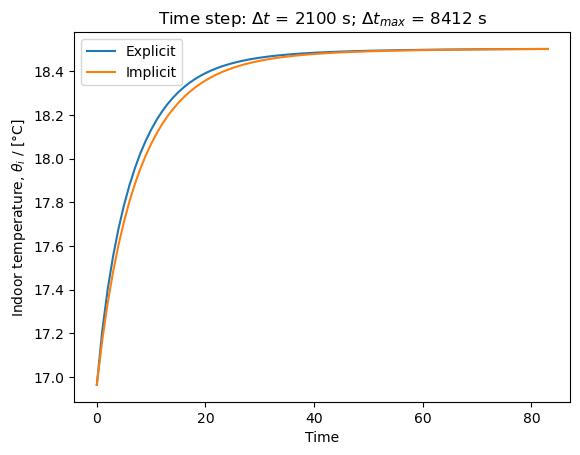

In [40]:
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0                      # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix

for k in range(u.shape[0] - 1):
    #Euler explicit:
    θ_exp.iloc[k + 1] = (I + Δt * As)\
        @ θ_exp.iloc[k] + Δt * Bs @ u.iloc[k]
   
    #Euler implicit:
    θ_imp.iloc[k + 1] = np.linalg.inv(I - Δt * As)\
        @ (θ_imp.iloc[k] + Δt * Bs @ u.iloc[k])
    
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / [°C]')
ax.set_title(f'Time step: $Δt$ = {Δt:.0f} s; $Δt_{{max}}$ = {max_Δt:.0f} s')
plt.show()

### Discussion

When using a time step close to the maximum time step defined by eigen-value analysis, the results for Euler explicit are not good: they oscillate rather than following the results of Euler implicit. However, when the time step is smaller (here, we divided it by 4), Euler explicit gives results that are almost indentical to Euler implicit. 

## Response to weather

### Inputs

The inputs are modelled by temperature and flow rate sources. A control volume is can be :
- A temperature source if the variation of its temperature is independent on the flow rate through the control surface (e.g., outdoor air temperature, indoor air temperature set-point);
- A flow-rate source if the variation of its flow-rate is independent on the temperature difference on the control surface (e.g., solar radiation, auxiliary heat gains).

The sources can be represented by the weather (e.g., outdoor air temperature, solar radiation) or by schedules (e.g., indoor air temperature set-point or internal gains).

*Objectives:*
- Read the inputs for weather simulation.
- Calculate the solar radiation on outdoor and indoor surfaces of the walls.
- Define the schedules for indoor air temperature and auxiliary heat gains.

#### Start and end time
The simulation will be done from start_date to end_date indicated in the format MM-DD HH:MM:SS (month-day, hour:minute:second).

The weather data are for a typical meteorological year (TMY). The choice of 2000 for the year is arbitrary; it is used in order to respect the format YYYY-MM-DD HH:MM:SS.

In [41]:
start_date = '02-01 12:00:00'
end_date = '02-07 18:00:00'

start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-02-01 12:00:00 	start date
2000-02-07 18:00:00 	end date


#### Input data set

The input_data_set is a DataFrame which contains the values of the temperature and the flow-rate sources in time. In our case, the sources are:

- $T_0$ - outdoor air temperature, °C;
- $T_{i,sp}$ - setpoint of indoor air temperature, °C;
- $T_{\infty,sp}$ - setpoint of the adjacent room air temperature, °C;
- $\Phi_0$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;


The temperature and flow-rate sources are obtained from weather data ($T_0$, $\Phi_0$, $\Phi_i$) and from schedules ($T_{i,sp}$,$T_{\infty,sp}$, $\dot{Q}_i$).

#####  Weather: outdoor temperature and solar radiation
Dynamic simulation needs time series of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface .

From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar direct normal irradiance (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or diffuse sky radiation), W/m²;

and delete the other data.



In [42]:
filename = '../BE_Confort_thermique/weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

###### Outdoor temperature

There are three temperature sources:

- $T_0 = [T_{0(0)}, T_{0(1)}, ..., T_{0(n-1)}]$ is the time series of the oudoor temperature at discrete time $t = [t_0, t_1, ... , t_{n-1}]$.

- $T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]$ is the time series of the setpoint indoor temperature at discrete time $t = [t_0, t_1, ... , t_{n-1}]$.

- $T_{\infty, sp} = [T_{{\infty, sp}(0)}, T_{{\infty, sp}(1)}, ..., T_{{\infty, sp}(n-1)}]$ is the time series of the setpoint indoor temperature at discrete time $t = [t_0, t_1, ... , t_{n-1}]$.

In [43]:
# Temperature sources
T0 = weather['temp_air']

###### Solar irradiance on the walls

Total solar irradiance:

The characteristics of the outdoor walls are given in the file ./pd/bldg/walls_out.csv.

For the surface orientation given by slope, azimuthand latitude, and the albedo of the surface in front of the wall, by using the weather data, we can calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,

for hourly solar irradiance on a tilted surface.

In [44]:
# total solar irradiance
wall_out = pd.read_csv('./pd/bldg/walls_out.csv')
w0 = wall_out[wall_out['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['α0'].values[0])

The total solar irradiance on the wall  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

In [45]:
Etot = rad_surf.sum(axis=1)

Flow rate sources:

The radiation absorbed by the outdoor surface of the wall is:

$$\Phi_0 = \alpha_{w,SW} S_w E_{tot}$$

where:
- $\alpha_{w,SW}$ is the absorptance of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiance on the wall, W/m².

In [46]:
# solar radiation absorbed by the outdoor surface of the wall
Φ0 = w0['α1'].values[0] * w0['Area'].values[0] * Etot

# window glass properties
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass
S_g = 9         # m², surface area of glass

# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot

##### Schedules
###### Indoor air temperature set-point

$$T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]$$

is the time series of the setpoint indoor temperature at discrete time $t = [t_0, t_1, ... , t_{n-1}]$. Let's consider the indoor temperature set-point constant, $T_{i, sp} = 20 \, \mathrm{°C}$.

We can define hourly schedules of the indoor air temperature set-point

In [47]:
# indoor air temperature set-point
Ti_sp = pd.Series(20, index=T0.index)

Ti_day, Ti_night = 20, 16

Ti_sp = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in T0.index.hour],
    index=T0.index)

###### Adjacent room air temperature set-point

$$T_{\infty, sp} = [T_{{\infty, sp}(0)}, T_{{\infty, sp}(1)}, ..., T_{{\infty, sp}(n-1)}]$$

is the time series of the setpoint adjacent room temperature at discrete time $t = [t_0, t_1, ... , t_{n-1}]$. Let's consider the indoor temperature set-point constant, $T_{\infty, sp} = 20 \, \mathrm{°C}$.

In [48]:
# adjacent room air temperature set-point
T_inf = pd.Series(20, index=T0.index)

#### Auxiliary heat

$$\dot Q_a = [\dot Q_a (0), \dot Q_a (1), ..., \dot Q_a (n-1)]$$

is the time series of the internal sources (e.g., occupants, electrical devices, etc.) at discrete time $t = [t_0, t_1, ... , t_{n-1}]$.
Let's consider the auxiliary heat flow $\dot{Q}_a = 0 \, \mathrm{W}$ constant for the whole duration of the simulation.

In [49]:
# auxiliary (internal) sources
Qa = 0 * np.ones(weather.shape[0])

### Input data set
The input is formed by the vectors of time series of temperature sources $\left [ T_o, T_{i,sp}, T_{\infty,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a} \right ]^T$:

$$u_{set} = 
\begin{bmatrix}
T_o\\  
T_{i,sp}\\
T_{\infty,sp}\\
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
T_{\infty,sp(0)} & T_{\infty,sp(1)}& ... & T_{\infty,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
\dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}
\end{bmatrix}$$

where the input data set is:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.

$T_{\infty,sp}$: time series vector of the adjacent room setpoint temperatures, °C.

$\Phi_o$: time series vector of solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall;

$\Phi_i$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall;

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), in W.

In [50]:
# Input data set
input_data_set = pd.DataFrame({'T0': T0, 'Ti_sp': Ti_sp,'T_inf' : T_inf,'Φ0': Φ0, 'Φi': Φi, 'Qa': Qa})
input_data_set

,T0,Ti_sp,T_inf,Φ0,Φi,Qa
2000-02-01 12:00:00+01:00,10.0,20,20,1032.750000,51.637500,0.0
2000-02-01 13:00:00+01:00,11.0,20,20,1012.500000,50.625000,0.0
2000-02-01 14:00:00+01:00,13.0,20,20,4230.647363,211.532368,0.0
2000-02-01 15:00:00+01:00,11.0,20,20,587.250000,29.362500,0.0
2000-02-01 16:00:00+01:00,11.0,20,20,486.000000,24.300000,0.0
...,...,...,...,...,...,...
2000-02-07 14:00:00+01:00,6.0,20,20,2285.857086,114.292854,0.0
2000-02-07 15:00:00+01:00,6.0,20,20,2047.038328,102.351916,0.0
2000-02-07 16:00:00+01:00,6.0,20,20,784.102037,39.205102,0.0
2000-02-07 17:00:00+01:00,5.0,20,20,101.250000,5.062500,0.0


## Discussion

We could also change the start date and end date to obtain longer periods and summmer periods, and so annual results.

At the same time, we could schedule the auxiliary heat sources (for instance the use of the oven or the washing machine because both are used for "long-time" durations (going from 1 to 3 or 4 hours) and generate heat).


### Simulation: perfect controller


The simulation is done by numerical integration of the state-space representation by using the description of the model as a thermal circuit, the input data set, and the weather data.

*Objectives:*
- Resample the inputs at time step.
- Create input vector in time.
- Integrate in time the state-space model.
- Plot the results.

The following assumptions are done:
- The indoor air temperature is controlled by a P-controller having the gain $K_p$.
- The adjacent room air temperature is controlled by a P-controller having the gain $K_{p,\infty}$.
- The time integration is done by using Euler explicit or Euler implicit.
- The time step is imposed at a value $\Delta t$.

In [51]:
#The gains for the controllers are defined above in the subsection "Proportional controllers" of the section "Modelling"
#The gains can be changed there.

Δt = 100    # s, imposed time step

#### Resample input data set

The weather data and the scheduled sources are at the time-step of 1 h. The data needs to be resampled at time step `dt` used for numerical integration.

In [52]:

#Resampling:
input_data_set = input_data_set.resample(
    str(Δt) + 'S').interpolate(method='linear')
input_data_set

,T0,Ti_sp,T_inf,Φ0,Φi,Qa
2000-02-01 12:00:00+01:00,10.000000,20.0,20.0,1032.7500,51.637500,0.0
2000-02-01 12:01:40+01:00,10.027778,20.0,20.0,1032.1875,51.609375,0.0
2000-02-01 12:03:20+01:00,10.055556,20.0,20.0,1031.6250,51.581250,0.0
2000-02-01 12:05:00+01:00,10.083333,20.0,20.0,1031.0625,51.553125,0.0
2000-02-01 12:06:40+01:00,10.111111,20.0,20.0,1030.5000,51.525000,0.0
...,...,...,...,...,...,...
2000-02-07 17:53:20+01:00,4.288889,20.0,20.0,11.2500,0.562500,0.0
2000-02-07 17:55:00+01:00,4.266667,20.0,20.0,8.4375,0.421875,0.0
2000-02-07 17:56:40+01:00,4.244444,20.0,20.0,5.6250,0.281250,0.0
2000-02-07 17:58:20+01:00,4.222222,20.0,20.0,2.8125,0.140625,0.0


#### Input vector in time

In the _input data set_ an input appears only once. However, the _input vector_ may contain the same time series multiple time. Therefore, we need to obtain the _input vector_ from the _input data set_.

The input in time is formed by the vectors of time series of temperature sources $\left [ T_0, T_0 ,T_0, T_{i,sp}, T_{\infty, sp}\right]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_0, \Phi_i, \dot{Q_a} \right ]^T$:

$$u = 
\begin{bmatrix}
T_0\\ 
T_0\\ 
T_0\\ 
T_{i,sp}\\ 
T_{\infty,sp}\\
\Phi_0\\ 
\Phi_i\\ 
\dot{Q}_a
\end{bmatrix}
= \begin{bmatrix}
T_{0(0)} & T_{0(1)}& ... & T_{0(n-1)}\\ 
T_{0(0)} & T_{0(1)}& ... & T_{0(n-1)}\ \\ 
T_{0(0)} & T_{0(1)}& ... & T_{0(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
 T_{\infty,sp(0)} & T_{\infty,sp(1)}& ... & T_{\infty,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}
\end{bmatrix}$$

The *input vector* `u` is obtained from the *input data set*, $T_o, T_{i,sp}, T_{\infty,sp}, \Phi_o, \Phi_i, \dot Q_a$, by using the order of the sources given in the state-space model, `us`: `q0` = $T_o$, `q8` = $T_o$, `q10` = $T_o$, `q11` = $T_{i,sp}$, `θ0` = $\Phi_o$, `θ4` = $\Phi_i$, `θ6` = $\dot Q_a$.

In [53]:
T0=input_data_set.loc[:,'T0']
Ti_sp=input_data_set.loc[:,'Ti_sp']
T_inf=input_data_set.loc[:,'T_inf']
Φ0=input_data_set.loc[:,'Φ0']
Φi=input_data_set.loc[:,'Φi']
Qa=input_data_set.loc[:,'Qa']


u = pd.concat([T0, T0, T0, Ti_sp, T_inf, Φ0, Φi, Qa], axis=1)
u.columns.values[[0,1,2,3,4,5,6,7]] = ['T0', 'T0', 'T0', 'Ti_sp', 'T_inf','Φ0', 'Φi', 'Qa']
pd.DataFrame(u)

,T0,T0,T0,Ti_sp,T_inf,Φ0,Φi,Qa
2000-02-01 12:00:00+01:00,10.000000,10.000000,10.000000,20.0,20.0,1032.7500,51.637500,0.0
2000-02-01 12:01:40+01:00,10.027778,10.027778,10.027778,20.0,20.0,1032.1875,51.609375,0.0
2000-02-01 12:03:20+01:00,10.055556,10.055556,10.055556,20.0,20.0,1031.6250,51.581250,0.0
2000-02-01 12:05:00+01:00,10.083333,10.083333,10.083333,20.0,20.0,1031.0625,51.553125,0.0
2000-02-01 12:06:40+01:00,10.111111,10.111111,10.111111,20.0,20.0,1030.5000,51.525000,0.0
...,...,...,...,...,...,...,...,...
2000-02-07 17:53:20+01:00,4.288889,4.288889,4.288889,20.0,20.0,11.2500,0.562500,0.0
2000-02-07 17:55:00+01:00,4.266667,4.266667,4.266667,20.0,20.0,8.4375,0.421875,0.0
2000-02-07 17:56:40+01:00,4.244444,4.244444,4.244444,20.0,20.0,5.6250,0.281250,0.0
2000-02-07 17:58:20+01:00,4.222222,4.222222,4.222222,20.0,20.0,2.8125,0.140625,0.0


#### Initial conditions
We define the initial value of the state-vector (it can be zero or different from zero).

In [54]:
# Initial conditions
θ0 = 20                     # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0

#### Time integration
The state-space model is integrated in time by using Euler backward (or implicit) method for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

or Euler forward (or explicit) method for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$.

In [55]:
#Choice of the method: Euler implicit or explicit:
explicit_Euler=True

I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + Δt * As) @ θ.iloc[k] + Δt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - Δt * As) @ (θ.iloc[k] + Δt * Bs @ u.iloc[k])

#### Outputs

From the time variation of state variable $\theta_s$ we obtain the time variation of the output $y$ (i.e., indoor temperature):

$$y = C_s \theta_s + D_s u$$

In [56]:
# outputs
y = (Cs @ θ.T + Ds @  u.T).T

y = y.rename(columns={y.columns[0]: 'θ6'})

the variation in time of the heat flow of the HVAC system

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.


and of the adjacent room system : 

$$q_{\infty} = K_{p\infty} (T_{\infty,sp} - \theta_i) = K_{p\infty} (T_{\infty,sp} - y)$$

where $K_{p\infty}$ is the gain of the P-controller and $T_{\infty,sp}$ is the temperature setpoint for the adjacent room.

In [57]:
#HVAC system: 
S = 9                  # m², surface area of the principal room
q_HVAC = Kp * (u['Ti_sp'] - y['θ6']) / S  # W/m²
print(q_HVAC)

#Adjacent room:
S = 9                  # m², surface area of the adjacent room
q_inf = Kp_inf * (u['T_inf'] - y['θ6']) / S  # W/m²
y['θ6']

2000-02-01 12:00:00+01:00    140.077880
2000-02-01 12:01:40+01:00    139.997991
2000-02-01 12:03:20+01:00    139.917483
2000-02-01 12:05:00+01:00    139.836361
2000-02-01 12:06:40+01:00    139.754628
                                ...    
2000-02-07 17:53:20+01:00    207.573997
2000-02-07 17:55:00+01:00    207.726649
2000-02-07 17:56:40+01:00    207.879407
2000-02-07 17:58:20+01:00    208.032270
2000-02-07 18:00:00+01:00    208.185238
Freq: 100S, Length: 5401, dtype: float64


2000-02-01 12:00:00+01:00    18.739299
2000-02-01 12:01:40+01:00    18.740018
2000-02-01 12:03:20+01:00    18.740743
2000-02-01 12:05:00+01:00    18.741473
2000-02-01 12:06:40+01:00    18.742208
                               ...    
2000-02-07 17:53:20+01:00    18.131834
2000-02-07 17:55:00+01:00    18.130460
2000-02-07 17:56:40+01:00    18.129085
2000-02-07 17:58:20+01:00    18.127710
2000-02-07 18:00:00+01:00    18.126333
Freq: 100S, Name: θ6, Length: 5401, dtype: float64

#### Plots

We select the data to plot:

- $T_0$, outdoor temperature, in °C;
- $\theta_i$, indoor temperature, in °C;
- $E_{tot}$, total solar irradiance, in W/m²;
- $q_{HVAC}$, thermal load, i.e., the power that the HVAC system needs to deliver in order to maintain the indoor air temperature at its set-point, in W.
- $q_{\infty}$, thermal load, i.e., the power needed in the other room to maintain the air temperature at its set-point, in W.

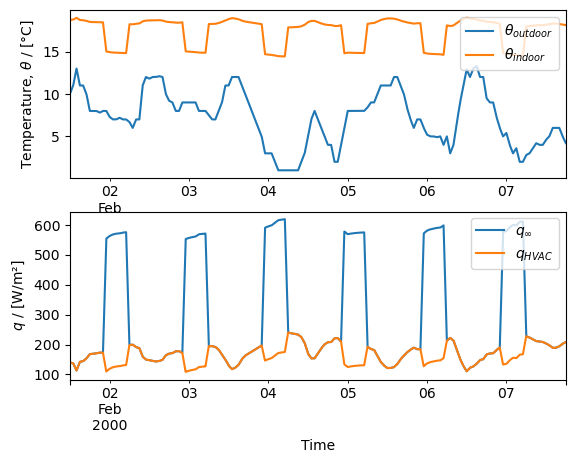

In [58]:
#Data to plot: 
data = pd.DataFrame({'T0': input_data_set['T0'],
                     'θi': y['θ6'],
                     'q_HVAC': q_HVAC,
                    'q_inf':q_inf})


#Plots:
fig, axs = plt.subplots(2, 1)
data[['T0', 'θi']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / [°C]')

axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['q_inf', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='$q$ / [W/m²]')
axs[1].set(xlabel='Time')
axs[1].legend(['$q_{\infty}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show();

#### Discussion

Effect of the proportional controller:

The gains for the controllers are defined above in the subsection "Proportional controllers" of the section "Modelling", we set different values for the gains to study their effect on the dynamic results:

The higher the value of the gain value (for both $K_p$ and $K_{p\infty}), the higher the value of the thermal load. 
- If both controllers are 0, then the building is free-running so the indoor temperature follows the variation of the outdoor temperature. 
- If the proportionnal controller of the HVAC system is perfect (in our case equal to 1e3) then the room temperature goes down to 15°C before increasing again (meaning that the heating system switched on). The same goes for the system in the other room.
- If both controller are the same (equal to 1e3), the power needed to maintain the temperature in the other room is about 3 to 4 times higher than the one needed in the main room.

With our modelling, the HVAC system can be both a heating system but also a cooling one, when the outdoor temperature is superior to the indoor's.

## References

1. C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024, open access preprint: [HAL-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)

2. C. Ghiaus (2021). Dynamic Models for Energy Control of Smart Homes, in *S. Ploix M. Amayri, N. Bouguila (eds.) Towards Energy Smart Homes*, Online ISBN: 978-3-030-76477-7, Print ISBN: 978-3-030-76476-0, Springer, pp. 163-198 (ref.)
[DOI 10.1007/978-3-030-76477-7_5](https://doi.org/10.1007/978-3-030-76477-7_5), open access preprint: [HAL 03578578](https://hal.archives-ouvertes.fr/hal-03578578/document)

3. J.A. Duffie, W. A. Beckman, N. Blair (2020) [Solar Engineering of Thermal Processes](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf), 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

4. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html) Annexe à l’arrêté du 19 juillet 2006

5. H. Recknagel, E. Sprenger, E.-R. Schramek (2013) Génie climatique, 5e edition, Dunod, Paris. ISBN 978-2-10-070451-4

6. J.R. Howell et al. (2021) Thermal Radiation Heat Transfer 7th edition, ISBN 978-0-367-34707-0, [A Catalogue of Configuration Factors](http://www.thermalradiation.net/indexCat.html)

7. J. Widén, J. Munkhammar (2019) [Solar Radiation Theory](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf), Uppsala University

